# Лабораторная работа №4

Постановка задачи:
1) Разберите теоретическое описание и реализуйте метод стохастической оптимизации (к примеру, метод имитации отжига);
2) Сравните его эффективность на методах и примерах из лаб. 1 и/или лаб 2.Приведите примеры, иллюстрирующие разницу в результатах и
эффективности (количество вызовов функции, скорости) применения методов из лаб. 1 и/или лаб 2 и методов стохастической оптимизации.
3) Дополнительное задание 1
optuna: Примените методы библиотеки к примерам из лаб. 1 и/или лаб. 2.
Изучите параметры вызываемых библиотечных функций. Проанализируйте полученные результаты
4) Дополнительное задание 2
optuna: Примените методы библиотеки к любым выделенным hyperпараметрам
из лаб. 2 и/или лаб. 3. Изучите параметры вызываемых библиотечных функций. Проанализируйте полученные результаты.

Блок с необходимыми библиотеками, а так же с различным константами

In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
from functools import partial
from abc import ABC, abstractmethod
import random
import math
import optuna

START_POINT = np.array([-0.4, 0.4])
ALPHA = 0.067
EPSILON = 1e-6
MAX_ITER = int(1e4)

ALPHA_FOR_ANNEALING = 0.99
T_START = 100
T_MIN = 0.1

# Функции, использующиеся в коде

In [2]:
class Function(ABC):
    def __init__(self):
        self.count_apply = 0
        self.count_gradient = 0
        self.count_hessian = 0

    @abstractmethod
    def get_ans(self) -> (np.array, float):
        pass

    @abstractmethod
    def name(self) -> str:
        pass

    @abstractmethod
    def _apply(self, arguments: np.array) -> float:
        pass

    def apply(self, arguments: np.array) -> float:
        self.count_apply += 1
        return self._apply(arguments)

    @abstractmethod
    def _gradient(self, arguments: np.array) -> np.array:
        pass

    def gradient(self, arguments: np.array) -> np.array:
        self.count_gradient += 1
        return self._gradient(arguments)

    @abstractmethod
    def _hessian(self, arguments: np.array) -> np.array:
        pass

    def hessian(self, arguments: np.array) -> np.array:
        self.count_hessian += 1
        return self._hessian(arguments)

    def clear(self):
        self.count_apply = 0
        self.count_gradient = 0
        self.count_hessian = 0

    def print3D(self):
        x = np.linspace(-6, 6, 400)
        y = np.linspace(-6, 6, 400)
        X, Y = np.meshgrid(x, y)
        Z = self.apply([X, Y])
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, cmap='viridis')
        fig.colorbar(surf)
        plt.show()

    def print2D(self, initial_guess):
        x = np.linspace(-3, 3, 400)
        y = np.linspace(-3, 3, 400)
        X, Y = np.meshgrid(x, y)
        Z = self.apply([X, Y])
        plt.figure(figsize=(8, 6))
        contour = plt.contour(X, Y, Z, levels=np.logspace(-1, 3, 50), cmap='viridis')
        plt.colorbar(contour)
        plt.title(f'{self.name()} Function with Optimization Path')
        plt.xlabel('x')
        plt.ylabel('y')
        path = [initial_guess]
        opt.minimize(self.apply, initial_guess, jac=self.gradient, callback=lambda point: path.append(point.copy()))
        path = np.array(path)
        plt.plot(path[:, 0], path[:, 1], 'r*-')
        plt.show()

## Функция Розенброка для двух переменных

$Rosenbrock(x, y) = (1 - x)^2 + 100 (y - x^2)^2$

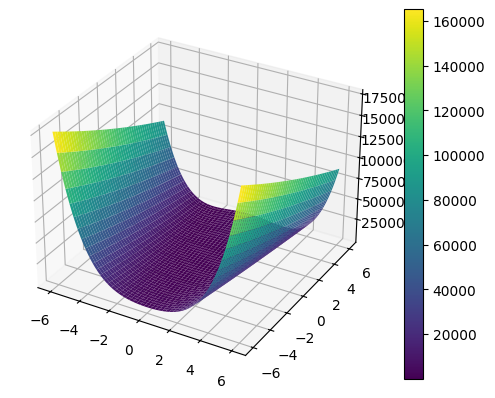

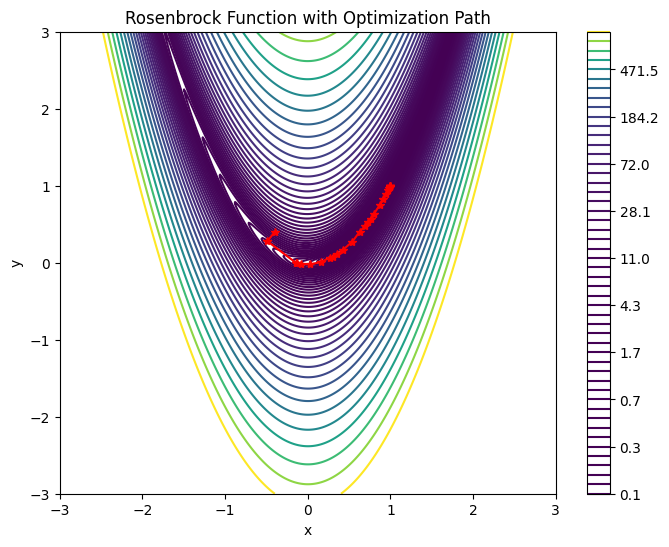

In [3]:
class Rosenbrock(Function):
    def get_ans(self) -> (np.array, float):
        return np.array([1., 1.]), 0.

    def name(self) -> str:
        return "Rosenbrock"

    def _apply(self, arguments: np.array) -> float:
        x, y = arguments
        return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

    def _gradient(self, arguments: np.array) -> np.array:
        x, y = arguments
        return np.array([-2 * (1 - x) - 400 * x * (y - x ** 2), 200 * (y - x ** 2)])

    def _hessian(self, arguments: np.array) -> np.array:
        x, y = arguments
        return np.array([
            [1200 * x ** 2 - 400 * y + 2, -400 * x],
            [-400 * x, 200]
        ])


rosenbrock = Rosenbrock()
rosenbrock.print3D()
rosenbrock.print2D(START_POINT)

## Функция Растригина
$Rastrigin(x, y) = 20 + x^2 - 10 \cos(2\pi x) + y^2 - 10 \cos(2\pi y)$

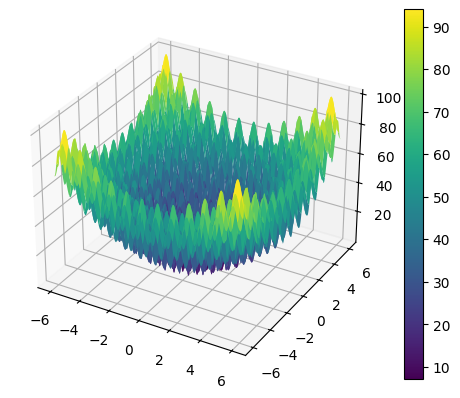

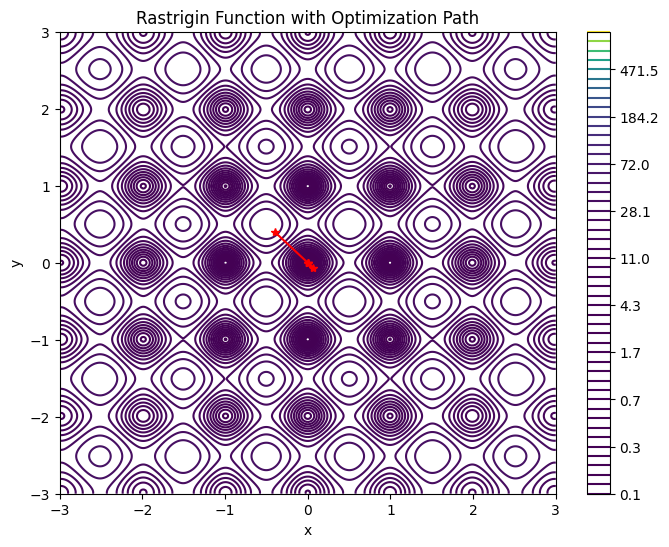

In [4]:
class Rastrigin(Function):
    def get_ans(self) -> (np.array, float):
        return np.array([0., 0.]), 0.

    def name(self) -> str:
        return "Rastrigin"

    def _apply(self, arguments: np.array) -> float:
        x, y = arguments
        return 20 + x ** 2 - 10 * np.cos(2 * np.pi * x) + y ** 2 - 10 * np.cos(2 * np.pi * y)

    def _gradient(self, arguments: np.array) -> np.array:
        x, y = arguments
        df_dx = 2 * x + 20 * np.pi * np.sin(2 * np.pi * x)
        df_dy = 2 * y + 20 * np.pi * np.sin(2 * np.pi * y)
        return np.array([df_dx, df_dy])

    def _hessian(self, arguments: np.array) -> np.array:
        x, y = arguments
        h_xx = 2 + 40 * np.pi ** 2 * np.cos(2 * np.pi * x)
        h_yy = 2 + 40 * np.pi ** 2 * np.cos(2 * np.pi * y)
        return np.array([[h_xx, 0],
                         [0, h_yy]])


rastrigin = Rastrigin()
rastrigin.print3D()
rastrigin.print2D(START_POINT)

## Функция Ackley
$Ackley(x, y) = -20\exp(-0.2\sqrt{0.5(x^2 + y^2)}) - \exp(0.5(\cos(2\pi x) + \cos(2\pi y)) + e + 20$

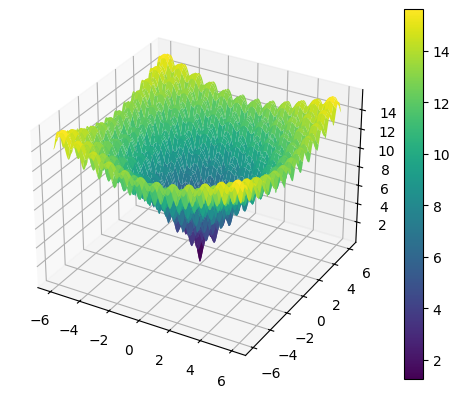

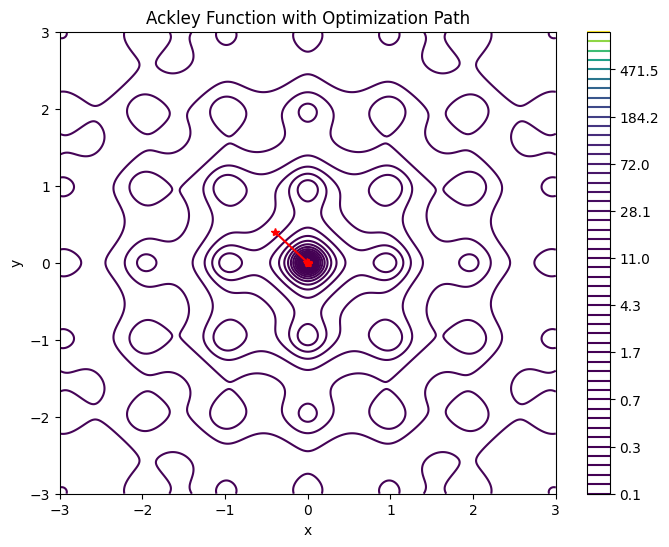

In [5]:
class Ackley(Function):
    def get_ans(self) -> (np.array, float):
        return np.array([0., 0.]), 0.

    def name(self) -> str:
        return "Ackley"

    def _apply(self, arguments: np.array) -> float:
        x, y = arguments
        part1 = -20 * np.exp(-0.2 * np.sqrt(0.5 * (x ** 2 + y ** 2)))
        part2 = -np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))
        return part1 + part2 + np.e + 20

    def _gradient(self, arguments: np.array) -> np.array:
        x, y = arguments
        factor = np.exp(-0.2 * np.sqrt(0.5 * (x ** 2 + y ** 2)))
        common = 0.2 / np.sqrt(0.5 * (x ** 2 + y ** 2))
        df_dx = x * common * factor + np.pi * np.sin(2 * np.pi * x) * np.exp(
            0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))
        df_dy = y * common * factor + np.pi * np.sin(2 * np.pi * y) * np.exp(
            0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))
        return np.array([df_dx, df_dy])

    def _hessian(self, arguments: np.array) -> np.array:
        x, y = arguments
        a = 0.2
        b = 2 * np.pi
        common_factor = np.exp(-a * np.sqrt(0.5 * (x ** 2 + y ** 2)))
        h_xx = common_factor * (a ** 2 * x ** 2 / (0.5 * (x ** 2 + y ** 2)) - a / np.sqrt(
            0.5 * (x ** 2 + y ** 2)) + b ** 2 * np.cos(b * x)) + a * x ** 2 * common_factor ** 2 / (
                       2 * (x ** 2 + y ** 2) ** 1.5)
        h_yy = common_factor * (a ** 2 * y ** 2 / (0.5 * (x ** 2 + y ** 2)) - a / np.sqrt(
            0.5 * (x ** 2 + y ** 2)) + b ** 2 * np.cos(b * y)) + a * y ** 2 * common_factor ** 2 / (
                       2 * (x ** 2 + y ** 2) ** 1.5)
        h_xy = x * y * (a ** 2 * common_factor / (0.5 * (x ** 2 + y ** 2)) + a * common_factor ** 2 / (
                2 * (x ** 2 + y ** 2) ** 1.5))
        return np.array([[h_xx, h_xy],
                         [h_xy, h_yy]])


ackley = Ackley()
ackley.print3D()
ackley.print2D(START_POINT)

In [6]:
all_functions = [rosenbrock, rastrigin, ackley]
method_results = []
method_names = []

In [7]:
def parse_result(results: list[(Function, np.array, int)]) -> pd.DataFrame:
    global EPSILON
    data = {
        "Точка минимума": [i[1] for i in results],
        "Значение функции в точке": [i[0].apply(i[1]) for i in results],
        "Количество итераций": [i[2] for i in results],
        "Количество вызовов функции": [i[0].count_apply for i in results],
        "Количество вызовов градиента": [i[0].count_gradient for i in results],
        "Количество вызовов гессиана": [i[0].count_hessian for i in results],
    }
    indexes = [i[0].name() for i in results]
    df = pd.DataFrame(data)
    df.index = indexes
    return df


def create_result(method_name: str, method, method_args: list):
    global all_functions
    results = []
    for func in all_functions:
        partial_method = partial(method, func)
        func.clear()
        results.append(partial_method(*method_args))
    method_results.append(parse_result(results))
    method_names.append(method_name)

# Методы минимизации

## Метод Ньютона с постоянным шагом

In [8]:
def newton_method_with_const_step(func: Function, x0: np.array) -> (Function, np.array, int):
    global EPSILON, MAX_ITER
    x = np.copy(x0)
    iter_num = 0
    for i in range(MAX_ITER):
        grad = func.gradient(x)
        hess = func.hessian(x)
        delta = -np.linalg.solve(hess, grad)
        x += delta
        if np.linalg.norm(delta) < EPSILON:
            break
        iter_num += 1
    return func, x, iter_num

In [9]:
create_result("Метод Ньютона с постоянным шагом", newton_method_with_const_step, [START_POINT])

## Метод Ньютона с одномерным поиском

In [10]:
def line_search(func, x, gradient_function, step_direction, alpha=1, beta=0.5):
    global EPSILON
    while func(x + alpha * step_direction) > func(x) - 0.5 * alpha * np.dot(gradient_function(x), step_direction):
        alpha *= beta
        if alpha < EPSILON:
            break
    return alpha

In [11]:
def newton_method_with_line_search(func: Function, line_search_func, x0: np.array) -> (Function, np.array, int):
    global EPSILON, MAX_ITER
    x = np.copy(x0)
    iter_num = 0
    for i in range(MAX_ITER):
        gradient = func.gradient(x)
        hessian = func.hessian(x)
        step_direction = np.linalg.solve(hessian, -gradient)
        alpha = line_search_func(func.apply, x, func.gradient, step_direction)
        x += alpha * step_direction
        if np.linalg.norm(gradient) < EPSILON:
            break
        iter_num += 1
    return func, x, iter_num

In [12]:
create_result("Метод Ньютона с одномерным поиском", newton_method_with_line_search, [line_search, START_POINT])

## Функции из 1-ой лабораторной - Градиентный спуск и метод нулевого порядка

In [13]:
def gradient_descent(func: Function, x0: np.array, alpha_f) -> (Function, np.array, int):
    global ALPHA, EPSILON, MAX_ITER
    x = np.copy(x0)
    last = func.apply(x)
    num_iters = 0
    for i in range(MAX_ITER):
        counted_alpha_f = alpha_f(func, x)
        x -= counted_alpha_f * func.gradient(x)
        new = func.apply(x)
        if abs(new - last) < EPSILON:
            break
        last = new
        num_iters += 1
    return func, x, num_iters

In [14]:
def alpha_ternary(func: Function, x0: np.array) -> float:
    global EPSILON
    l = -10
    r = 10
    gradient = func.gradient(x0)
    while r - l > EPSILON:  # Условие продолжения цикла на основе точности
        m1 = (2 * l + r) / 3
        m2 = (l + 2 * r) / 3
        if func.apply(x0 - m1 * gradient) > func.apply(x0 - m2 * gradient):
            l = m1
        else:
            r = m2
    return (l + r) / 2

In [15]:
def nelder_mead(func: Function, x0: np.array) -> (Function, np.array, int):
    global EPSILON, MAX_ITER
    result = opt.minimize(func.apply, np.copy(x0), method="nelder-mead",
                          options={'xatol': EPSILON, "maxiter": MAX_ITER})
    return func, result.x, result['nit']

In [16]:
create_result("Градиентный спуск", gradient_descent, [START_POINT, alpha_ternary])
create_result("Метод Нелдера-Мида", nelder_mead, [START_POINT])

## Scipy.optimize методы

#### Newton-CG

In [17]:
def minimize_NewtonCG(func: Function, x0: np.array) -> (Function, np.array, int):
    result = opt.minimize(func.apply, np.copy(x0), method='Newton-CG', jac=func.gradient, hess=func.hessian)
    return func, result.x, result['nit']

In [18]:
create_result("Newton-CG", minimize_NewtonCG, [START_POINT])

#### Broyden-Fletcher-Goldfarb-Shanno

In [19]:
def minimize_BFGS(func: Function, x0: np.array, use_functions: bool) -> (Function, np.array, int):
    if use_functions:
        result = opt.minimize(func.apply, np.copy(x0), method='BFGS', jac=func.gradient)
    else:
        result = opt.minimize(func.apply, np.copy(x0), method='BFGS')
    return func, result.x, result['nit']

In [20]:
create_result("BFGS", minimize_BFGS, [START_POINT, True])
create_result("BFGS разностным методом", minimize_BFGS, [START_POINT, False])

## Метод Ньютона с одномерным поиском по правилу Вольфе
Правило Вольфе состоит из двух условий при выборе шага в методе градиентного спуска:
1. Условие достаточного убывания: $f(x + \alpha p) \leq f(x) + c_1 \alpha \nabla f(x)^Tp$
2. Условие кривизны: $\nabla f(x + \alpha p)^Tp \geq c_2 \nabla f(x)^Tp$

Где
* $\alpha$ - размер шага
* $p$ - направление поиска
* $c_1$ и $c_2$ - константы Вольфе, обычно $0 < c_1 < c_2 < 1$

In [21]:
def wolfe_line_search(f, x, gradient_function, p, alpha=1.0, c1=0.0001, c2=0.9):
    global MAX_ITER

    def phi(alpha):
        return f(x + alpha * p)

    def phi_prime(alpha):
        return np.dot(gradient_function(x + alpha * p), p)

    alpha0 = 0
    alpha1 = alpha
    phi0 = phi(alpha0)
    phi_prime0 = phi_prime(alpha0)

    for i in range(MAX_ITER):
        if phi(alpha1) > phi0 + c1 * alpha1 * phi_prime0 or (i > 0 and phi(alpha1) >= phi(alpha0)):
            return zoom(alpha0, alpha1, phi, phi_prime, c1, c2)
        phi_prime1 = phi_prime(alpha1)
        if abs(phi_prime1) <= -c2 * phi_prime0:
            return alpha1
        if phi_prime1 >= 0:
            return zoom(alpha1, alpha0, phi, phi_prime, c1, c2)
        alpha0 = alpha1
        alpha1 = 2 * alpha1  # Здесь можно использовать другой способ обновления alpha1

    return alpha1


# для уточнения размера шага, когда нужные условия ещё не достигнуты
def zoom(a_lo, a_hi, phi, phi_prime, c1, c2):
    while True:
        a_j = (a_lo + a_hi) / 2
        if phi(a_j) > phi(0) + c1 * a_j * phi_prime(0) or phi(a_j) >= phi(a_lo):
            a_hi = a_j
        else:
            phi_prime_j = phi_prime(a_j)
            if abs(phi_prime_j) <= -c2 * phi_prime(0):
                return a_j
            if phi_prime_j * (a_hi - a_lo) >= 0:
                a_hi = a_lo
            a_lo = a_j
        if abs(a_hi - a_lo) < 1e-5:
            break
    return a_j

In [22]:
create_result("Метод Ньютона с одномерным поиском по правилу Вольфе", newton_method_with_line_search,
              [wolfe_line_search, START_POINT])

# Метод имитации отжига

Моделирование похожего процесса используется для решения задачи глобальной оптимизации, состоящей в нахождении такой точки или множества точек, на которых достигается минимум некоторой целевой функции $F(x)$ ("энергия системы"), где ${x}\in X$ (${x}$ — "состояние системы", $X$ — множество всех состояний). 

Алгоритм поиска минимума методом имитации отжига предполагает свободное задание:
* ${x_0}\in X$ — начального состояния системы;
* оператора $A({x},i):X\times \mathbb{N}\to X$, случайно генерирующего новое состояние системы после i-ого шага с учётом текущего состояния ${x}$ (этот оператор, с одной стороны, должен обеспечивать достаточно свободное случайное блуждание по пространству $X$, а с другой — работать в некоторой степени целенаправленно, обеспечивая быстроту поиска);
* $T_i>0$ — убывающей к нулю положительной последовательности, которая задаёт аналог понижающейся температуры в кристалле. Скорость остывания (закон убывания) также может задаваться (и варьироваться) произвольно, что придаёт алгоритму значительной гибкости.

Алгоритм генерирует процесс случайного блуждания по пространству состояний $X$.
Решение ищется последовательным вычислением точек ${x_0},\;{x_1},\;{x_2},\;\ldots,\;$ пространства $X$; каждая точка, начиная с ${x_1}$, «претендует» на то, чтобы лучше предыдущих приближать решение. На каждом шаге алгоритм (который описан ниже) вычисляет новую точку и понижает значение величины (изначально положительной), понимаемой как «температура». 

Последовательность этих точек (состояний) получается следующим образом. К точке ${x_i}$ применяется оператор $A$, в результате чего получается точка-кандидат ${x^*_i}=A(x_i,i)$, для которой вычисляется соответствующее изменение "энергии" $\Delta F_i=F({x^*_i})-F({x_i})$. Если энергия понижается ($\Delta F_i\leq 0$), осуществляется переход системы в новое состояние: ${x_{i+1}}={x^*_i}$. Если энергия повышается ($\Delta F_i>0$), переход в новое состояние может осуществиться лишь с некоторой вероятностью, зависящей от величины повышения энергии и текущей температуры, в соответствии с законом распределения Гиббса:
: $P({x^*_i}\to{x_{i+1}}\mid{x_i})=\exp(-\Delta F_i/{T_i})$
Если переход не произошёл, состояние системы остаётся прежним: ${x_{i+1}}={x_i}$.
Алгоритм останавливается по достижении точки, которая оказывается при температуре ноль.

Алгоритм имитации отжига похож на градиентный спуск, но за счёт случайности выбора промежуточной точки и возможности выбираться из локальных минимумов должен реже застревать в локальных, но не глобальных минимумах, чем градиентный спуск. Алгоритм имитации отжига не гарантирует нахождения минимума функции, однако при правильной настройке генерации случайной точки в пространстве $X$, как правило, происходит улучшение начального приближения.


In [23]:
def simulated_annealing(func: Function, x0: np.array, T, T_min, alpha, delta, all) -> (Function, np.array, int):
    global EPSILON, MAX_ITER
    iteration = 0
    x = x0
    best_x = x0
    best_f = func.apply(x)
    # print(x, best_f)
    while T > T_min:
        x_new = []
        if all == 1:
            for p in x:
                x_new.append(random.uniform(p - delta, p + delta))
        else:
            ind = random.randint(0, len(x) - 1)
            for i in range(len(x)):
                x_new.append(x[i] if i != ind else random.uniform(x[i] - delta, x[i] + delta))
        f_new = func.apply(x_new)
        if f_new < best_f:
            best_f = f_new
            best_x = x_new
        elif random.random() < math.exp(-(f_new - func.apply(x)) / T):
            x = x_new
        T *= alpha
        iteration += 1
    return func, best_x, iteration

In [24]:
# for change in [0, 1]:
#     for a in [0.99, 0.999]:
#         for delta in [1, 2, 0.5, 0.1]:
#             create_result(
#                 "Type: " + str(change) + " Метод Иммитации отжига с альфа:" + str(a) + " с дельта: " + str(delta),
#                 simulated_annealing, [START_POINT, 100, 0.01, a, delta, change])
create_result("Метод Иммитации отжига", simulated_annealing, [START_POINT, T_START, T_MIN, ALPHA_FOR_ANNEALING, 1, 0])


# Допольнительное задание 1 (optuna)

В данном блоке при помощи библиотеке optuna минимизируем функции из 2 лабораторной

In [25]:
# import optuna
def objective(func):
    def inner(trial):
        x = trial.suggest_float('x', -10, 10)
        y = trial.suggest_float('y', -10, 10)
        return func.apply([x, y])

    return inner


optuna.logging.disable_default_handler()  # Disable the default handler.


def optuna_easy(func: Function, cnt) -> (Function, np.array, int):
    study = optuna.create_study()
    study.optimize(objective(func), n_trials=cnt)

    res = study.best_params
    return func, [res.get('x'), res.get('y')], cnt


create_result("Поиск минимума с помощью optuna", optuna_easy, [100])


# Допольнительное задание 2 (optuna)

В данном блоке при помощи библиотеке optuna будем выбираем гиперпараметры для метода, которые вы подбирали вручную, для лучшего результата

In [26]:
def line_search_paramter(alpha0, beta0):
    def inner(func, x, gradient_function, step_direction, alpha=alpha0, beta=beta0):
        global EPSILON
        while func(x + alpha * step_direction) > func(x) - 0.5 * alpha * np.dot(gradient_function(x), step_direction):
            alpha *= beta
            if alpha < EPSILON:
                break
        return alpha

    return inner

In [27]:
# import optuna
def objective(trial):
    alpha = 1
    beta = 0.5
    x = trial.suggest_float('x', -10, 10)
    y = trial.suggest_float('y', -10, 10)
    f, x, _ = newton_method_with_line_search(rastrigin, line_search_paramter(alpha, beta), [x, y])
    return f.apply(x)

MAX_ITER = 100
# optuna.logging.disable_default_handler()  # Disable the default handler.

study = optuna.create_study()
study.optimize(objective, n_trials=20)

res = study.best_params
print(res)
MAX_ITER = int(1e4)
create_result("Поиск гиперпараметров с помощью optuna Метод Ньютона с одномерным поисĸом",
              newton_method_with_line_search, [line_search_paramter(1, 0.5), [res.get("x"), res.get("y")]])


{'x': 0.06904780890836815, 'y': 3.1362464547646782}


# Результаты

In [28]:
pd.concat(method_results, keys=method_names)

Точка минимума  \
Метод Ньютона с постоянным шагом                   Rosenbrock                                         [1.0, 1.0]   
                                                   Rastrigin           [-0.5025460365546747, 0.5025460365546747]   
                                                   Ackley              [-0.5246004403432846, 0.5246004403432846]   
Метод Ньютона с одномерным поиском                 Rosenbrock                                         [1.0, 1.0]   
                                                   Rastrigin           [-0.4011254596957898, 0.4011254596957898]   
                                                   Ackley              [-0.4003223474016263, 0.4003223474016263]   
Градиентный спуск                                  Rosenbrock            [-4.377267298975207, 19.16699524749247]   
                                                   Rastrigin             [-0.994958636255959, 0.994958636255959]   
                                                   Ackley        [3.024652036850364e-08, -3.024652036850364e-08]   
Метод Нелдера-Мида                                 Rosenbrock           [1.0000001615887069, 1.0000003199312815]   
                                                   Rastrigin    [1.6526793596742224e-07, 2.4253564788889367e-07]   
                                                   Ackley       [4.0960187121463696e-07, 3.3228608644316066e-07]   
Newton-CG                                          Rosenbrock           [0.9999998956988365, 0.9999997909808134]   
                                                   Rastrigin     [8.271806125530277e-25, -8.271806125530277e-25]   
                                                   Ackley      [0.00023158324531724638, -0.00023158324531724638]   
BFGS                                               Rosenbrock           [0.9999998017639598, 0.9999996005936909]   
                                                   Rastrigin     [5.130723271844976e-10, -5.130816749858934e-10]   
                                                   Ackley       [-2.849345868904942e-15, -2.008984576136174e-15]   
BFGS разностным методом                            Rosenbrock           [0.9999953203068281, 0.9999906301313104]   
                                                   Rastrigin   [-2.1280291851040987e-09, -8.173470566704734e-09]   
                                                   Ackley       [-1.288849832243852e-09, -3.892312570500508e-09]   
Метод Ньютона с одномерным поиском по правилу В... Rosenbrock                                         [1.0, 1.0]   
                                                   Rastrigin         [-0.40856825083337256, 0.40856825083337256]   
                                                   Ackley              [-0.4025378190660122, 0.4025378190660122]   
Метод Иммитации отжига                             Rosenbrock           [0.9933441658613065, 1.0181638732665843]   
                                                   Rastrigin       [-0.013696154984620845, 0.024669144229976236]   
                                                   Ackley                                            [-0.4, 0.4]   
Поиск минимума с помощью optuna                    Rosenbrock       [-0.14669016886696598, 0.018188157146510564]   
                                                   Rastrigin       [-1.0316199881402928, 0.00027937464786970123]   
                                                   Ackley             [0.15467569639616502, 0.07638570305699191]   
Поиск гиперпараметров с помощью optuna Метод Нь... Rosenbrock                          [1.0, 0.9999999999999998]   
                                                   Rastrigin                           [0.0, 2.9848557010394816]   
                                                   Ackley           [1.0225283416244306e-11, 1.5115660905771124]   

                                                               Значение функции в точке  \
Метод Ньютона с постоянным шагом                   Rosenbrock 

1. Метод имитации отжига показал результат на уровне метода Ньютона с линейным поиском, при этом для нахождение минимума, нам не нужно знать градиент и гессиан, а только вычиселние функции. Если увеличить количество итараций (за счёт изменения температуры и коэфицента понижения градусов, можно увеличить точность и но увеличиться количество запусков).
2. В дополнительном задании 1 использовали optuna для нахождение минимума функции, в нём можно указать сколько ровно итераций выполнения будет выполнено и для выполенения нужно только знания о функции.
3. В дополнительном задании 2 использовали optuna для нахождения гиперпараметров (искали стартовую точку с маленьким лимитом на итарация в методе Ньютона), а затем запускали на полном при найденом оптимуме по мненинию optuna. Как итог точность и количество итераций стало для метода Ньютона меньше.